In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
import ntpath
import mixamo_helper as mm_helper
from mixamo_helper import Mixamo
from IPython.display import clear_output
import copy

## **load mixamo json**

In [2]:
json_object = None
file_name = 'output/mixamo_attack.gif.json_mixamo.json' 
with open(file_name) as f:
    json_object = json.load(f)

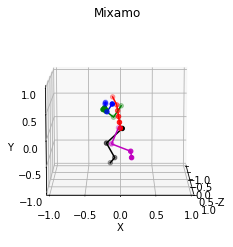

In [3]:
current_frame = 55
mm_helper.draw_mixamo(json_object, current_frame, 0)
current_keypoints = json_object["frames"][current_frame]["keypoints3D"]

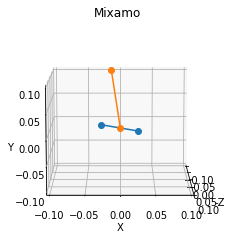

In [4]:
draw_list = [[Mixamo.LeftUpLeg, Mixamo.RightUpLeg], [Mixamo.Hips, Mixamo.Spine]]

mm_helper.draw_list(json_object, current_frame, draw_lists=draw_list, range= 0.1, azim= 0)

## **Math**

In [5]:
import glm
import pyglm_helper as glmh

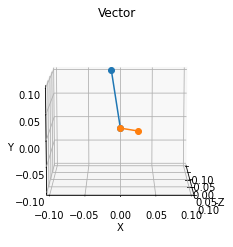

vec3(    0.0276472,   -0.0273498,    0.0906916 )
vec3(   -0.0278332,    0.0282433,   -0.0917552 )


In [6]:
glm_list, visibility_list, parent_list = mm_helper.frame_json_to_glm_vec_list(json_object, current_frame)
hip_v = glm_list[Mixamo.Hips]
spine_v = glm_list[Mixamo.Spine]
leftleg_v = glm_list[Mixamo.LeftUpLeg]
rightleg_v = glm_list[Mixamo.RightUpLeg]

glmh.draw_list([hip_v, spine_v,leftleg_v, rightleg_v], [[0, 1],[0, 2]], azim = 0, range = 0.1)
print(leftleg_v)
print(rightleg_v)

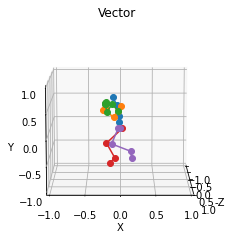

In [7]:
idx_group = mm_helper.get_idx_group()
glmh.draw_list([v for v in glm_list], idx_group, azim=0)

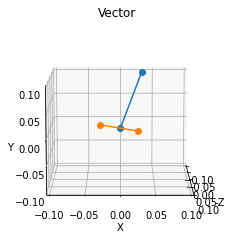

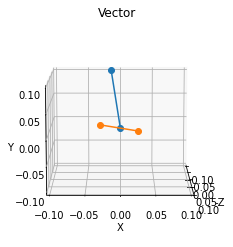

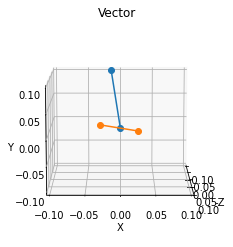

transform*b_left:  vec3(    0.0276472,   -0.0273498,    0.0906916 )
transform*b_right:  vec3(   -0.0280056,    0.0277043,    -0.091867 )
transform*b_spine:  vec3(   -0.0138245,     0.109246,    0.0371596 )
left:  vec3(    0.0276472,   -0.0273498,    0.0906916 )
right:  vec3(   -0.0278332,    0.0282433,   -0.0917552 )
spine:  vec3(   -0.0135667,     0.108997,    0.0379769 )


In [8]:
rightleg_b = glm.vec3(-glm.distance(hip_v, rightleg_v), 0, 0)
leftleg_b = glm.vec3(glm.distance(hip_v, leftleg_v), 0, 0)
spine_b = glm.vec3(0,glm.distance(hip_v, spine_v), 0)

hip_gizmo = glmh.Gizmo(r = hip_v)
leftleg_gizmo = glmh.Gizmo(r = leftleg_b)
spine_gizmo = glmh.Gizmo(r = spine_b)

transform = hip_gizmo.calc_rotation_matrix(leftleg_gizmo.get_origin(),
                               glm_list[Mixamo.LeftUpLeg])
hip_gizmo_r = hip_gizmo.rotate(transform)

transform1 = hip_gizmo_r.calc_roll(transform*spine_gizmo.get_origin(),
                               glm_list[Mixamo.Spine])

transform1 = transform*transform1

transform2 = glmh.calc_hip_transform_1(glm_list, hip_gizmo, leftleg_gizmo, spine_gizmo)


glmh.draw_list([transform*hip_v, transform*spine_b, transform*leftleg_b, transform*rightleg_b], [[0, 1],[2,3]], azim = 0, range = 0.1)
glmh.draw_list([transform1*hip_v, transform1*spine_b, transform1*leftleg_b, transform1*rightleg_b], [[0, 1],[2,3]], azim = 0, range = 0.1)
glmh.draw_list([transform2*hip_v, transform2*spine_b, transform2*leftleg_b, transform2*rightleg_b], [[0, 1],[2,3]], azim = 0, range = 0.1)
print('transform*b_left: ',transform1*leftleg_b)
print('transform*b_right: ', transform1*rightleg_b)
print('transform*b_spine: ', transform1*spine_b)
print('left: ', leftleg_v)
print('right: ', rightleg_v)
print('spine: ', spine_v)

In [9]:
def get_hip_transform(glmList):
    b_spine = glm.vec3(0.0, glm.distance(glmList[Mixamo.Spine], glmList[Mixamo.Hips]), 0.0)
    b_leftleg = glm.vec3(glm.distance(glmList[Mixamo.Hips], glmList[Mixamo.LeftUpLeg]), 0, 0)
    norm_b_spine = glm.normalize(b_spine)
    norm_spine = glm.normalize(glmList[Mixamo.Spine])
    norm_b_leftleg = glm.normalize(b_leftleg)
    norm_leftleg = glm.normalize(glmList[Mixamo.LeftUpLeg])
    transform = glm.rotate(glm.mat4(1.0), glm.acos(glm.dot(norm_b_leftleg, norm_leftleg)) ,glm.cross(b_leftleg, leftleg_v))
    transform = glm.rotate(transform,glm.acos(glm.dot(norm_b_spine, norm_spine)), glm.vec3(1.0, 0.0, 0.0))
    return glm.inverse(transform)

In [10]:
frame_size = len(json_object["frames"])
print(frame_size)
all_frame_glm_list = [] 
for idx in range(0 , frame_size):
    glm_list1, visibility_list, parent_list = mm_helper.frame_json_to_glm_vec_list(json_object, idx)
    hip_transform = get_hip_transform(glm_list1)
    all_frame_glm_list.append(copy.deepcopy([hip_transform*v for v in glm_list1]))

# glmh.glm_lists_to_gif(all_frame_glm_list, fps=json_object["ticksPerSecond"], save_path='./screenshot/', is_axes_move= True)

101


In [11]:
def find_hips(pixel3d_json):
    if pixel3d_json["name"] == 'Hips':
        return [True, pixel3d_json]
    else:
        for child in pixel3d_json["child"]:
            is_find, result = find_hips(child)
            if is_find:
                return [is_find, result]
        return [False, None]

In [12]:
pix3d_json_object = None
file_name = 'pixel3d_json/cyb_model.json' 
with open(file_name) as f:
    pix3d_json_object = json.load(f)
root_node = glmh.ModelNode()
is_find, result =  find_hips(pix3d_json_object["node"])
if is_find:
    root_node.set_pixel3d(result)


In [13]:
root_node1 = glmh.ModelNode()
root_node1.set_mixamo(result, mm_helper.get_mixamo_name_idx_map())

In [14]:
root_node1.normalize(glm_list, mm_helper.get_mixamo_name_idx_map())
print("d:",glm.distance(glm_list[Mixamo.Hips], glm_list[Mixamo.LeftUpLeg]))

d: 0.09867797791957855


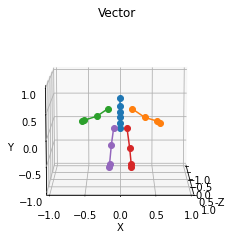

In [15]:
result_vec_list = []
result_group_list = []
root_node1.get_vec_and_group_list(result_vec_list, result_group_list)
glmh.draw_list([v for v in result_vec_list], result_group_list ,range= 1.0, azim= 0)
# glmh.glm_list_to_gif(result_vec_list, result_group_list, save_path="./screenshot/", range=1.0)

In [16]:
root_node1.calc_animation(glm_list, mm_helper.get_mixamo_name_idx_map() )

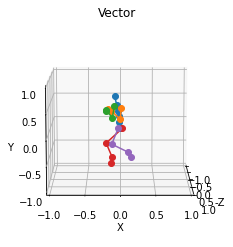

In [17]:
rv = []
rg = []
root_node1.get_vec_and_group_list(rv, rg, is_apply_tmp_transform= True)
glmh.draw_list([v for v in rv ], rg, range= 1.0, azim= 00)
# glmh.glm_list_to_gif(rv, rg, save_path="./screenshot/", range=1.0)